Training Session

In [ ]:
from matplotlib.cbook import flatten
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

data_dir = '/content/drive/MyDrive/Colab Notebooks/PBL 3 CNN/train'

batch_size = 32
img_height = 180
img_width = 180

tf.random.set_seed(42)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3), seed=42),
    layers.RandomRotation(0.1, seed=42),
    layers.RandomZoom(0.1, seed=42),
  ]
)

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

(32, 180, 180, 3)
(32,)
0.0 0.73066676
58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 128)               1638528   
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                

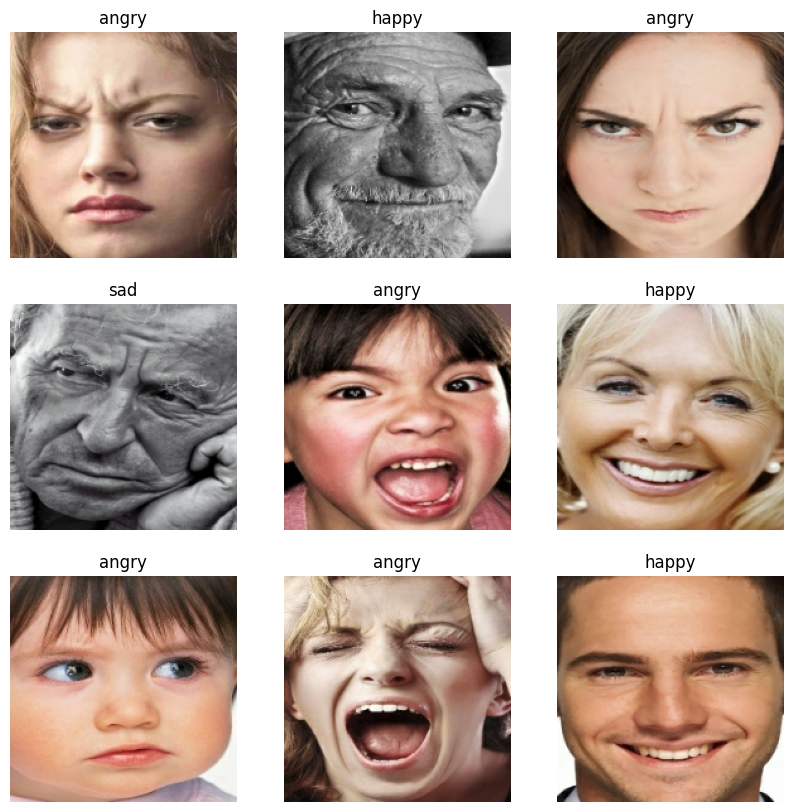

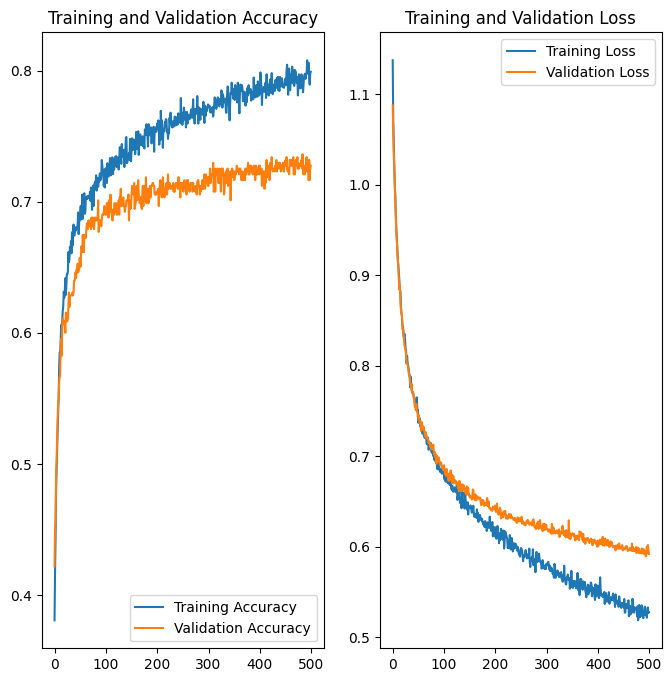

In [ ]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

opt = tf.keras.optimizers.experimental.Adadelta(learning_rate=0.002)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

epochs = 500
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
train_accuracy = history.history['accuracy'][-1]
print(f'Training Accuracy: {train_accuracy}')

validation_accuracy = history.history['val_accuracy'][-1]
print(f'Validation Accuracy: {validation_accuracy}')

loss = history.history['loss'][-1]
print(f'Loss: {loss}')

validation_loss = history.history['val_loss'][-1]
print(f'Validation Loss: {validation_loss}')

Training Accuracy: 0.7991223931312561
Validation Accuracy: 0.7274725437164307
Loss: 0.5274916887283325
Validation Loss: 0.5920125842094421


Testing Session

In [ ]:
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/PBL 3 CNN/test'

tf.random.set_seed(42)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Testing Accuracy: {test_accuracy}')

Found 569 files belonging to 3 classes.
18/18 [==============================] - 68s 2s/step - loss: 0.6834 - accuracy: 0.7047
Testing Accuracy: 0.7047451734542847


In [ ]:
from sklearn.metrics import f1_score

predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'F1 Score: {f1}')

18/18 [==============================] - 3s 100ms/step
F1 Score: 0.37122103767527326
